In [181]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.metrics import r2_score

from keras.layers import Dense,Dropout,SimpleRNN,LSTM
from keras.models import Sequential

plt.rcParams['font.family'] = 'Malgun Gothic'

# 데이터 로드

In [182]:
df = pd.read_csv('./train.csv')
df['시점'] = pd.to_datetime(df['시점'], format='%Y-%m-%d %H')
df.set_index('시점', inplace=True)
df

,구분,공급량
시점,,
2013-01-01 00:00:00,A,2497.129
2013-01-01 01:00:00,A,2363.265
2013-01-01 02:00:00,A,2258.505
2013-01-01 03:00:00,A,2243.969
2013-01-01 04:00:00,A,2344.105
...,...,...
2018-12-31 19:00:00,H,681.033
2018-12-31 20:00:00,H,669.961
2018-12-31 21:00:00,H,657.941


In [183]:
test = pd.read_csv('./test.csv')
test['시점'] = pd.to_datetime(test['시점'], format='%Y-%m-%d %H')
test.set_index('시점', inplace=True)
test

,구분
시점,
2019-01-01 00:00:00,A
2019-01-01 01:00:00,A
2019-01-01 02:00:00,A
2019-01-01 03:00:00,A
2019-01-01 04:00:00,A
...,...
2019-03-31 19:00:00,H
2019-03-31 20:00:00,H
2019-03-31 21:00:00,H


# 구분=D, hour=0 데이터 학습

In [184]:
# 구분=D, hour=0인 데이터 추출
df_D0 = df[(df['구분'] == 'D') & (df.index.hour == 0)]
df_D0.drop(columns='구분', inplace=True)
df_D0

,공급량
시점,
2013-01-01,1434.516
2013-01-02,1291.316
2013-01-03,1664.996
2013-01-04,1688.276
2013-01-05,1695.316
...,...
2018-12-27,1330.120
2018-12-28,1571.524
2018-12-29,1574.356


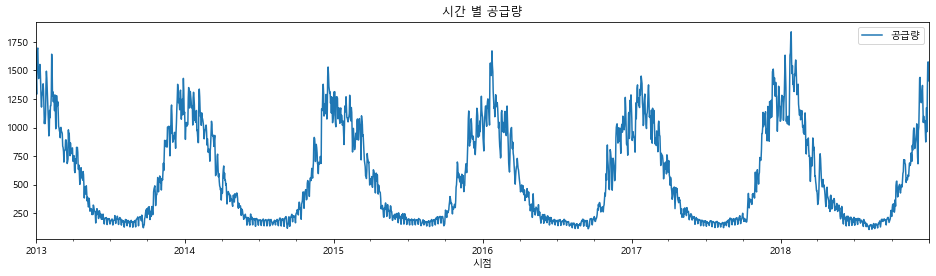

In [185]:
# 시간에 따른 값 확인
df_D0.plot(figsize=(16,4),legend=True)
plt.title('시간 별 공급량')
plt.show()

In [186]:
# minmax scaler로 정규화
scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(1, 2))
df_D0['공급량']=scaler.fit_transform(df_D0['공급량'].values.reshape(-1,1))
df_D0

,공급량
시점,
2013-01-01,1.766965
2013-01-02,1.684169
2013-01-03,1.900226
2013-01-04,1.913686
2013-01-05,1.917757
...,...
2018-12-27,1.706605
2018-12-28,1.846182
2018-12-29,1.847819


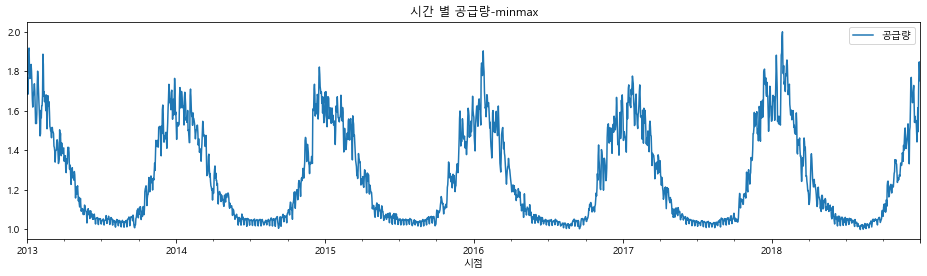

In [187]:
# 정규화 된 데이터 시각화
df_D0.plot(figsize=(16,4),legend=True)
plt.title('시간 별 공급량-minmax')
plt.show()

In [188]:
# LSTM에 들어갈 input data와 output data 형식에 맞게 생성해 주는 함수 정의
def load_data(data, seq_len):
    X = []
    y = []
    for i in range(seq_len, len(data)):
        X.append(data.iloc[i-seq_len : i, 0])
        y.append(data.iloc[i, 0])
    
    X = np.array(X)
    y = np.array(y)
        
    X = np.reshape(X, (X.shape[0], seq_len, 1))
            
    return [X, y]

In [189]:
# loss function을 custom으로 정의
def loss_nmae(true, pred):
    score = tf.reduce_mean((tf.math.abs(true-pred))/true)
    return score

In [190]:
# lstm model을 생성해주는 함수 정의
def build_model(X, learning_rate):
    lstm_model = Sequential()

    lstm_model.add(LSTM(40,activation="tanh",return_sequences=True, input_shape=(X.shape[1],1)))

    lstm_model.add(LSTM(40,activation="tanh",return_sequences=True))

    lstm_model.add(LSTM(40,activation="tanh",return_sequences=False))

    lstm_model.add(Dense(1))
    
    adam = tf.keras.optimizers.Adam(lr=learning_rate)

    lstm_model.compile(optimizer=adam, loss=loss_nmae)
    
    return lstm_model

In [191]:
# 하이퍼 파라미터를 입력 해 주면 10번 돌린 모델의 loss값을 출력 해주는 함수 선언
def grid_search(data, hyp_parameter):
    seq_len, learning_rate, epochs, batch_size = hyp_parameter
    val_loss_mean = 0
    X, y = load_data(data, seq_len)
    print('------------------------------------------------------')
    print('Hyper Parameter: seq_len=%d, learning_rate=%.2f, epochs=%d, batch_size=%d' %(seq_len, learning_rate, epochs, batch_size))
    for i in range(10):
        lstm_model = build_model(X, learning_rate)
        grid = lstm_model.fit(X, y, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=0)
        val_loss = grid.history['val_loss'][-1]
        print('> %d) nmae: %.5f' %(i+1, val_loss))
        val_loss_mean += val_loss
    val_loss_mean = val_loss_mean / 10
    print('>> nmae mean: %.5f' %val_loss_mean)
    return [seq_len, learning_rate, epochs, batch_size, val_loss_mean]

In [192]:
# 각각의 파라미터의 loss값을 계산 해 최적의 파라미터를 계산해주는 함수 선언
def search_parameter(data, hyp_parameters):
    NMAE = pd.DataFrame(columns=['seq_len', 'learning_rate', 'epochs', 'batch_size', 'nmae'])
    for hyp_parameter in hyp_parameters:
        result = grid_search(data, hyp_parameter)
        NMAE.loc[len(NMAE)] = result
    NMAE = NMAE.sort_values('nmae')
    seq_len = NMAE['seq_len'].iloc[0]
    learning_rate = NMAE['learning_rate'].iloc[0]
    epochs = NMAE['epochs'].iloc[0]
    batch_size = NMAE['batch_size'].iloc[0]
    nmae = NMAE['nmae'].iloc[0]
    print('-----------------------------------------------------------------------------------')
    print('최적 hyper parameter: seq_len=%d, learning_rate=%.2f, epohcs= %d, batch_size=%d -> nmae=%.5f' 
          %(seq_len, learning_rate, epochs, batch_size, nmae))
    return int(seq_len), learning_rate, int(epochs), int(batch_size)

In [193]:
# 하이퍼 파라미터를 만들어주는 함수 선언
def set_hyp_parameters():
    seq_len = [7, 28, 35]
    learning_rate = [0.005, 0.01, 0.05]
    n_epochs = [100, 200, 300]
    n_batch = [50, 100, 500]
    hyp_parameters = list()
    for i in seq_len:
        for j in learning_rate:
            for k in n_epochs:
                for l in n_batch:
                    cfg = [i, j, k, l]
                    hyp_parameters.append(cfg)
    print('number of hyper parameters: %d' % len(hyp_parameters))
    return hyp_parameters

In [194]:
# 하이퍼 파라미터 생성
hyp_parameters = set_hyp_parameters()

number of hyper parameters: 81


In [ ]:
# 최적 파라미터 계산
seq_len, learning_rate, epochs, batch_size = search_parameter(df_D0, hyp_parameters)

------------------------------------------------------
Hyper Parameter: seq_len=7, learning_rate=0.01, epochs=100, batch_size=50
> 1) nmae: 0.02229
> 2) nmae: 0.02291
> 3) nmae: 0.02549
> 4) nmae: 0.02435
> 5) nmae: 0.02246
> 6) nmae: 0.02368
> 7) nmae: 0.02684
> 8) nmae: 0.02227
> 9) nmae: 0.02267
> 10) nmae: 0.02243
>> nmae mean: 0.02354
------------------------------------------------------
Hyper Parameter: seq_len=7, learning_rate=0.01, epochs=100, batch_size=100
> 1) nmae: 0.02754
> 2) nmae: 0.02588
> 3) nmae: 0.02491
> 4) nmae: 0.02331
> 5) nmae: 0.02672
> 6) nmae: 0.02775
> 7) nmae: 0.03158
> 8) nmae: 0.02276
> 9) nmae: 0.02218
> 10) nmae: 0.02693
>> nmae mean: 0.02596
------------------------------------------------------
Hyper Parameter: seq_len=7, learning_rate=0.01, epochs=100, batch_size=500
> 1) nmae: 0.04075
> 2) nmae: 0.03783
> 3) nmae: 0.03912
> 4) nmae: 0.05093
> 5) nmae: 0.03777
> 6) nmae: 0.03643
> 7) nmae: 0.03619
> 8) nmae: 0.04306
> 9) nmae: 0.03583
> 10) nmae: 0.

In [ ]:
# 계산된 파라미터로 LSTM 모델 학습
X, y = load_data(df_D0, seq_len)

lstm_model = Sequential()

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True, input_shape=(X.shape[1],1)))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=False))

lstm_model.add(Dense(1))

adam = tf.keras.optimizers.Adam(lr=learning_rate)

lstm_model.compile(optimizer=adam, loss=loss_nmae)
model = lstm_model.fit(X, y, epochs=epochs, batch_size=batch_size, validation_split=0.2)

lstm_model.summary()

# 구분=D, hour=0 데이터 예측

In [ ]:
# test에서 구분=D, hour=0인 데이터 추출
test_D0 = test[(test['구분'] == 'D') & (test.index.hour == 0)]
test_D0.drop(columns='구분', inplace=True)
test_D0

In [ ]:
# 공급량은 null으로 생성
test_D0['공급량'] = np.nan
test_D0

In [ ]:
# D0데이터에 train과 test결합
D0 = df_D0.append(test_D0)
D0

In [ ]:
# NaN값을 순서대로 하나씩 계산
for i in range(len(test_D0)):
    pred = lstm_model.predict(np.reshape(np.array(D0.dropna()[len(D0.dropna())-seq_len:]), (1, seq_len, 1)))
    D0.iloc[len(D0.dropna())] = pred

D0

In [ ]:
# 생성된 데이터 시각화
D0.plot(figsize=(16,4),legend=True)
plt.title('구분: D, 시간: 0, 시간 별 공급량')
plt.show()

In [ ]:
# 위에서 생성한 scaler를 활용하여 scale 복원
D0['공급량'] = scaler.inverse_transform(D0)
D0